## Problem Statement
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).This projects aims to help in  predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

## Data
This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website here:https://www.figure-eight.com/data-for-everyone/

Each sample in the train and test set has the following information:

* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* The location the tweet was sent from (may also be blank)

## Data Features
The dataset we are using contains the following columns
* id - a unique identifier for each tweet
* text - the text of the tweet
* location - the location the tweet was sent from (may be blank)
* keyword - a particular keyword from the tweet (may be blank)
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

## Importing Libraries

In [1]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 6.3 MB/s eta 0:00:00


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.7 MB/s eta 0:00:00


In [3]:
import re
import yaml
import nltk
import torch
import string
import unidecode
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

## Loading dataset

In [4]:
train_data = pd.read_csv('/content/drive/MyDrive/Kaggle Datasets/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Kaggle Datasets/test.csv')

print(f'train shape => {train_data.shape}')
print(f'test shape => {test_data.shape}')

train shape => (7613, 5)
test shape => (3263, 4)


In [20]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [21]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


We can see that some of the columns in the dataset have got null values

In [24]:
train_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [25]:
train_data.dropna(inplace=True)


In [26]:
train_data.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [27]:
test_data.dropna(inplace=True)

In [28]:
test_data.head()

,id,keyword,location,text
15,46,ablaze,London,Birmingham Wholesale Market is ablaze BBC News...
16,47,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...
17,51,ablaze,NIGERIA,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...
18,58,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...
19,60,ablaze,"Los Angeles, Califnordia",PSA: IÛªm splitting my personalities.\n\n?? t...


In [29]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2158 entries, 15 to 3250
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        2158 non-null   int64 
 1   keyword   2158 non-null   object
 2   location  2158 non-null   object
 3   text      2158 non-null   object
dtypes: int64(1), object(3)
memory usage: 84.3+ KB


## EDA

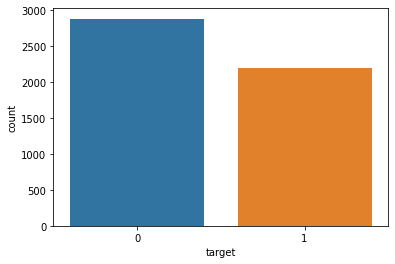

In [31]:
# Target Proportion
sns.countplot(data=train_data, x = "target");

In [33]:
# Random example of disaster tweet
train_data[train_data.target == 1].sample(1).text.values[0]

'???? #Krefeld: the incident happened in a chemical industry park! Emergency operations underway! A building reportly collapsed! @cnnbrk @ntvde'

In [34]:
# Random example of NO disaster tweet
train_data[train_data.target == 0].sample(1).text.values[0]

'.@BBCNews .@mwlippert #SouthKorea Dogs prepared!Electrocutedboiling waterfur machine ALL STILL ALIVE http://t.co/3a50DhZ7YI'

## Split Data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train_data.text.values,
                                                    train_data.target.values,
                                                    stratify=train_data.target.values,
                                                    test_size=0.2, random_state=1)

## Data Loader

In [36]:
class Data_gen(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, index):
        items = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
        if self.labels:
            items['labels'] = torch.tensor(self.labels[index])
        
        return items

    def __len__(self):
        return len(self.encodings["input_ids"])

In [37]:
batch_size = 8 * torch.cuda.device_count() if torch.cuda.device_count() > 0 else 8
batch_size

8

In [38]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
train_encoding = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=84)
valid_encoding = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=84)

train_set = Data_gen(train_encoding, y_train.tolist())
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

valid_set = Data_gen(valid_encoding, y_test.tolist())
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

## Model

In [40]:
total_steps = len(train_loader) * 3

model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

## Trainer

In [41]:
class Trainer:
    def __init__(self, model, epochs, scheduler, device, optimizer, auto_break_n):
        self.model = model
        self.epochs = epochs
        self.device = device
        self.scheduler = scheduler
        self.optimizer = optimizer
        self.auto_break_n = auto_break_n
        
        self.history_loss_train = []
        self.history_loss_valid = []
        self.history_score_train = []
        self.history_score_valid = []
        
        self.no_improvement_epoch = 0
        self.best_valid_score = 0
        
        self.model.to(self.device)
        
    def fit(self, train_loader, valid_loader=None):
        for epoch in range(self.epochs):
            self.model.train()
            
            losses = []
            
            preds = []
            targets = []
            
            for batch in tqdm(train_loader):
                inputs = {k: v.to(self.device) for k, v in batch.items()}
                target = batch["labels"]
                
                self.optimizer.zero_grad()
                
                outputs = self.model(**inputs)
                logits = outputs.logits
                loss = outputs.loss
                
                losses.append(loss.item())
            
                logits = logits.detach().cpu().numpy()
                
                targets.extend(target.tolist())
                preds.extend(np.argmax(logits, axis=1))
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
            
            train_loss = np.mean(losses)
            train_score = f1_score(preds, targets)
                                
            self.history_loss_train.append(train_loss)
            self.history_score_train.append(train_score)
            
            print("=" * 90)
            print(f"\033[1;34m=> {epoch + 1} <= epoch")
            print(f"\033[1;31m Train Loss: {train_loss}, Score: {train_score}")
            print("- " * 45)
            
            if valid_loader:
                valid_loss, valid_score = self.test_score(valid_loader)
                
                self.history_loss_valid.append(valid_loss)
                self.history_score_valid.append(valid_score)
                
                print(f"\033[1;31m Validation Loss : {valid_loss}, Score: {valid_score}")
                
                if self.scheduler:
                    self.scheduler.step()
                
                if self.history_score_valid[-1] > self.best_valid_score:
                    self.no_improvement_epoch = 0
                    self.best_valid_score = self.history_score_valid[-1]
                    self.save_model(epoch + 1)
                else:
                    self.no_improvement_epoch += 1
                    
                print(f"no improvement_iter = {self.no_improvement_epoch}")
                if self.no_improvement_epoch == self.auto_break_n:
                    self.save_model(epoch)
                    print('Auto_break !!!')                            
                    break
                
        
    def test_score(self, valid_loader):
        self.model.eval()
        losses = []
        targets = []
        preds = []

        for batch in tqdm(valid_loader):
            with torch.no_grad():
                inputs = {k: v.to(self.device) for k, v in batch.items()}
                target = batch["labels"]

                self.optimizer.zero_grad()

                outputs = self.model(**inputs)
                logits = outputs.logits
                logits = logits.detach().cpu().numpy()
                
                loss = outputs.loss.to(self.device)

                losses.append(loss.item())

                targets.extend(target.tolist())
                preds.extend(np.argmax(logits, axis=1))


        return np.mean(losses), f1_score(preds, targets)


    def save_model(self, n_epoch):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            "model.pth",
        )

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Fit

In [43]:
model = Trainer(model, 4, scheduler, device, optimizer, 2)

In [45]:
model.fit(train_loader, valid_loader)

100%|██████████| 508/508 [04:20<00:00,  1.95it/s]


=> 1 <= epoch
 Train Loss: 0.46188580463310397, Score: 0.7730582524271844
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 127/127 [00:19<00:00,  6.55it/s]


 Validation Loss : 0.4525356103233465, Score: 0.7565543071161048
no improvement_iter = 0


100%|██████████| 508/508 [04:21<00:00,  1.94it/s]


=> 2 <= epoch
 Train Loss: 0.36443993786357226, Score: 0.856447688564477
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 127/127 [00:19<00:00,  6.60it/s]


 Validation Loss : 0.6035073808445706, Score: 0.7552275522755227
no improvement_iter = 1


100%|██████████| 508/508 [04:20<00:00,  1.95it/s]


=> 3 <= epoch
 Train Loss: 0.2857422604469406, Score: 0.9053254437869823
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 127/127 [00:19<00:00,  6.54it/s]


 Validation Loss : 0.8928536980295568, Score: 0.737913486005089
no improvement_iter = 2
Auto_break !!!


## Plot Score/Loss

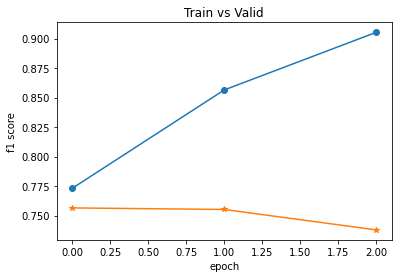

In [46]:
plt.plot(np.array(model.history_score_train),'-o')
plt.plot(np.array(model.history_score_valid),'-*')

plt.title('Train vs Valid')
plt.xlabel('epoch')
plt.ylabel("f1 score")
plt.show()

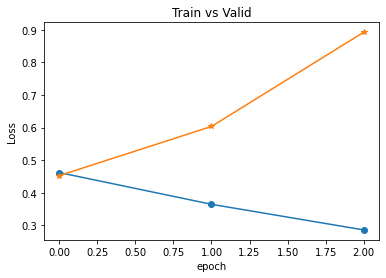

In [47]:
plt.plot(np.array(model.history_loss_train),'-o')
plt.plot(np.array(model.history_loss_valid),'-*')

plt.title('Train vs Valid')
plt.xlabel('epoch')
plt.ylabel("Loss")
plt.show()

## Loading Saved Model

In [48]:
model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)

model.load_state_dict(torch.load("model.pth", map_location=torch.device(device))['model_state_dict']);

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

## Loading Test data

In [49]:
test_encoding = tokenizer(test_data.text.to_list(), truncation=True, padding=True, max_length=84)

test_set = Data_gen(test_encoding, None)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## Inference

In [50]:
def inference(model, test_loader, device):
    model.eval()
    model.to(device)

    preds = []

    for batch in tqdm(test_loader):
        with torch.no_grad():
            inputs = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**inputs)
            logits = outputs.logits
            logits = logits.detach().cpu().numpy()

            preds.extend(np.argmax(logits, axis=1))
    return preds

## Get & Save Predict

In [52]:
submission = pd.read_csv('/content/drive/MyDrive/Kaggle Datasets/sample_submission.csv')

print(len(submission), len(inference(model, test_loader, device)))

#submission['target'] = inference(model, test_loader, device)
#submission.to_csv('../submission.csv', index=False)

#pd.read_csv("../submission.csv")

100%|██████████| 270/270 [00:28<00:00,  9.50it/s]

3263 2158


In [53]:
submission = submission[~submission.index.duplicated(keep='first')]
